In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import time
import pickle

from concurrent.futures import ProcessPoolExecutor, as_completed, ThreadPoolExecutor


import discretize 
from simpeg import maps
from simpeg.electromagnetics import time_domain as tdem

from simpeg.utils.solver_utils import get_default_solver

from simpeg.meta import MultiprocessingMetaSimulation #DaskMetaSimulation

In [2]:
Solver = get_default_solver()
Solver

pymatsolver.direct.pardiso.Pardiso

# set up models and mesh

In [3]:
rho_back = 500
sigma_back = 1./rho_back 

rho_target = 20
sigma_target = 1./rho_target

sigma_air = 1e-8

target_dips = np.r_[0, 15, 30, 45]

rx_times = np.logspace(np.log10(2e-5), np.log10(2e-3), 20)


In [4]:
def diffusion_distance(sigma, t):
    return 1260*np.sqrt(t/sigma)

In [5]:
diffusion_distance(sigma_target, 8e-3)

np.float64(504.0)

In [6]:
diffusion_distance(sigma_back, 8e-3)

np.float64(2520.0)

In [7]:
tx_height = np.r_[30]

rx_x = (np.linspace(-200, 200, 21))
rx_y = np.r_[0]
rx_z = tx_height

rx_locs = discretize.utils.ndgrid([rx_x, rx_y, rx_z])
rx_x

array([-200., -180., -160., -140., -120., -100.,  -80.,  -60.,  -40.,
        -20.,    0.,   20.,   40.,   60.,   80.,  100.,  120.,  140.,
        160.,  180.,  200.])

In [8]:
len(rx_x)

21

In [225]:
cell_width_x = 20
# cell_width_z = 10
cell_width_z = 20

core_depth_z = 180

n_pad_x = 7
n_pad_y = 7
n_pad_z = 7

pf = 1.55

n_core_x = int((rx_x.max()-rx_x.min())/cell_width_x + 1)
n_core_y = 3
n_core_air_z = int(rx_z[0] / cell_width_z)
n_core_subsurface_z = int(core_depth_z/cell_width_z)
n_core_z = int(n_core_air_z + n_core_subsurface_z)

hx = [
    (cell_width_x, n_pad_x, -pf), 
    (cell_width_x, n_core_x), 
    (cell_width_x, n_pad_x, pf)
]

hy = [
    (cell_width_x, n_pad_y, -pf), 
    (cell_width_x, n_core_y), 
    (cell_width_x, n_pad_y, pf)
]

hz = [
    (cell_width_z, n_pad_z, -pf), 
    (cell_width_z, n_core_z), 
    (cell_width_z, n_pad_z, pf)
]

mesh = discretize.TensorMesh(
    [hx, hy, hz]
)
mesh.origin = np.r_[
    -mesh.h[0].sum()/2, 
    -mesh.h[1].sum()/2,
    -mesh.h[2][:n_pad_z+n_core_subsurface_z].sum()
]

In [226]:
mesh

TensorMesh: 14,280 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     35     -1,365.13      1,365.13     20.00    429.88    1.55
   y     17     -1,185.13      1,185.13     20.00    429.88    1.55
   z     24     -1,335.13      1,175.13     20.00    429.88    1.55

In [227]:
def diffusion_distance(t, sigma): 
    return 1260 * np.sqrt(t/sigma)

In [228]:
diffusion_distance(2e-3, sigma_back)

np.float64(1260.0)

In [229]:
def dipping_target_indices(
    mesh, target_x_center, target_z_center, dip, target_thickness, target_xlim=None, target_ylim=None, target_zlim=None
): 
    """
    add a dipping target to the model. For now assumes the target dips in the x-direction
    """
    x_center = np.mean(target_x)
    slope = np.tan(-dip*np.pi/180)
    target_z = target_z_center + target_thickness / 2 * np.r_[-1, 1]
    
    z_bottom = (mesh.cell_centers[:, 0] - target_x_center) * slope + target_z.min()
    z_top = (mesh.cell_centers[:, 0] - target_x_center) * slope + target_z.max()

    indices = (
        (mesh.cell_centers[:, 2] >= z_bottom) &
        (mesh.cell_centers[:, 2] <= z_top) 
    )

    if target_xlim is not None: 
        indices = indices & (
            (mesh.cell_centers[:, 0] >= target_xlim.min()) &
            (mesh.cell_centers[:, 0] <= target_xlim.max())
        )
    if target_ylim is not None: 
        indices = indices & (
            (mesh.cell_centers[:, 1] >= target_ylim.min()) &
            (mesh.cell_centers[:, 1] <= target_ylim.max())
        )
    if target_zlim is not None: 
        indices = indices & (
            (mesh.cell_centers[:, 2] >= target_zlim.min()) &
            (mesh.cell_centers[:, 2] <= target_zlim.max())
        )
    return indices

In [296]:
models = {}

# target_x = np.r_[-105, 105]
target_x = np.r_[-60, 60]
target_y = np.r_[-np.inf, np.inf]
# target_z_center = -60
# target_z_center = -80
target_z_center=-70
# target_thickness = 40
target_thickness = 60

# background model
background = np.ones(mesh.n_cells) * sigma_air
background[mesh.cell_centers[:, 2] < 0] = sigma_back
models["background"] = background

for dip in target_dips:
    model = background.copy()
    indices = dipping_target_indices(
        mesh, target_x_center=0, target_z_center=target_z_center, 
        target_thickness=target_thickness, dip=dip, 
        target_xlim=target_x, 
        target_ylim=target_y,
        target_zlim=np.r_[-200, -20]
    )
    model[indices] = sigma_target
    models[f"target_{dip}"] = model



In [297]:
model_keys = list(models.keys())
model_keys

['background', 'target_0', 'target_15', 'target_30', 'target_45']

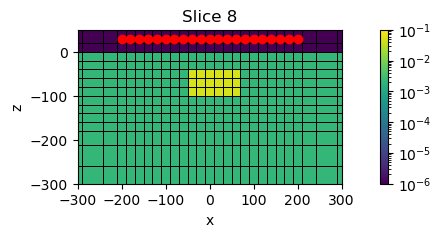

In [298]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2)) 

plt.colorbar(
    mesh.plot_slice(
        models["target_0"], 
        grid=True, 
        normal="y",
        pcolor_opts={"norm":LogNorm(1e-6, 1e-1)},
        grid_opts={"color":"k", "lw":0.5},
        ax=ax)[0], 
    ax=ax
)

ax.set_xlim(300*np.r_[-1, 1])
ax.set_ylim(np.r_[-300, 50])

ax.plot(rx_locs[:, 0], rx_locs[:, 2], "ro")
ax.set_aspect(1)

In [299]:
mesh.cell_centers_z[15]

np.float64(-10.00000000000017)

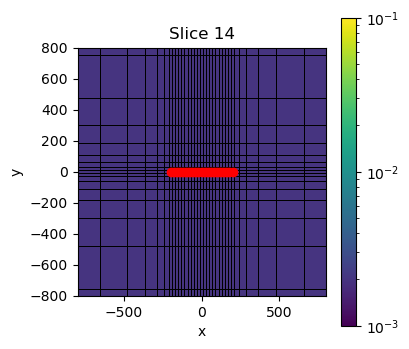

In [300]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4)) 

# mesh_local = mesh_list[-1]

plt.colorbar(
    mesh.plot_slice(
        models["target_0"], 
        grid=True, 
        normal="z",
        pcolor_opts={"norm":LogNorm(1e-3, 1e-1)},
        grid_opts={"color":"k", "lw":0.5},
        ax=ax,
        ind=14,
    )[0], 
    ax=ax
)

xlim = 800*np.r_[-1, 1]
ax.set_xlim(xlim)
ax.set_ylim(xlim)

ax.plot(rx_locs[:, 0], rx_locs[:, 1], "ro")
ax.set_aspect(1)


In [254]:
mesh_2d = discretize.TensorMesh(
    [mesh.h[0], mesh.h[2]], origin=np.r_[mesh.origin[0], mesh.origin[2]]
)


In [255]:
inds_2d_slice = (mesh.cell_centers[:, 1] < cell_width_x/2) & (mesh.cell_centers[:, 1] > -cell_width_x/2)

In [256]:
conductivity_models_2d = {}
for key, val in models.items():
    conductivity_models_2d[key] = val[inds_2d_slice]

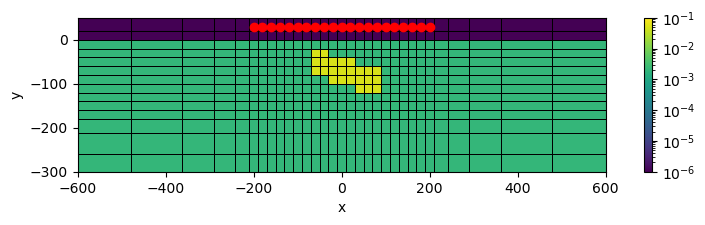

In [257]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2)) 

plt.colorbar(
    mesh_2d.plot_image(
        conductivity_models_2d["target_15"], 
        grid=True, 
        normal="y",
        pcolor_opts={"norm":LogNorm(1e-6, 1e-1)},
        grid_opts={"color":"k", "lw":0.5},
        ax=ax)[0], 
    ax=ax
)

ax.set_xlim(600*np.r_[-1, 1])
ax.set_ylim(np.r_[-300, 50])

ax.plot(rx_locs[:, 0], rx_locs[:, 2], "ro")
ax.set_aspect(1)

In [258]:
log_conductivity_models_2d = {}
active_cells = mesh_2d.cell_centers[:, 1] < 0

for key, val in conductivity_models_2d.items():
    log_conductivity_models_2d[key] = np.log(val[active_cells])

In [259]:
# def get_sim():
    # set up survey

def get_sim(
    mesh, mesh_2d, rx_locs=rx_locs, rx_times=rx_times, sigma_air=sigma_air
):
    source_list = []
    
    for i in range(rx_locs.shape[0]): 
        rx = tdem.receivers.PointMagneticFluxTimeDerivative(rx_locs[i, :], rx_times, orientation="z")
        src = tdem.sources.CircularLoop(
            receiver_list=[rx], location=rx_locs[i, :], orientation="z", radius=10, 
            waveform=tdem.sources.StepOffWaveform()
        )
        source_list.append(src)
    
    survey = tdem.Survey(source_list)
    
    # create simulation 
    time_steps = [
        (1e-6, 10), 
        (3e-6, 10), 
        (1e-5, 10), 
        (3e-5, 10), 
        (1e-4, 20), 
        # (3e-4, 20)
    ]   
    mapping = (
        maps.ExpMap(mesh) * 
        maps.Surject2Dto3D(mesh) * 
        maps.InjectActiveCells(mesh_2d, active_cells=active_cells, value_inactive=np.log(sigma_air))
    )
    simulation = tdem.simulation.Simulation3DElectricField(
        mesh=mesh,
        survey=survey,
        time_steps=time_steps,
        solver=Solver,
        sigmaMap=mapping, 
        solver_opts={}
    )
    return simulation

In [288]:
rx_ind = 0
rx_locs[rx_ind, :]

array([-200.,    0.,   30.])

In [289]:
sim = get_sim(
    mesh.copy(), mesh_2d.copy(), rx_locs = np.atleast_2d(rx_locs[rx_ind, :])
)

In [290]:
log_conductivity_models_2d.keys()

dict_keys(['background', 'target_0', 'target_15', 'target_30', 'target_45'])

In [291]:
%%time
key="background"
dpred_halfspace = sim.dpred(log_conductivity_models_2d[key])

CPU times: user 3min 25s, sys: 15.1 s, total: 3min 40s
Wall time: 14.1 s


In [292]:
def get_sim1d(thicknesses, rx_loc, rx_times=rx_times): 

    rx_sounding = tdem.receivers.PointMagneticFluxTimeDerivative(
        locations=rx_loc, times=rx_times, orientation="z"
    )
    src_sounding = tdem.sources.CircularLoop(
        receiver_list=[rx_sounding], location=rx_loc, 
        orientation="z", 
        radius=10, 
        waveform=tdem.sources.StepOffWaveform()
    )
    survey_sounding = tdem.Survey([src_sounding])
    
    sim1d = tdem.Simulation1DLayered(
        survey=survey_sounding, thicknesses=thicknesses, sigmaMap=maps.ExpMap()
    )
    return sim1d

In [293]:
sim1d = get_sim1d([], rx_loc=np.atleast_2d(rx_locs[rx_ind, :]))

In [294]:
dpred1d = sim1d.dpred(np.log(sigma_back))

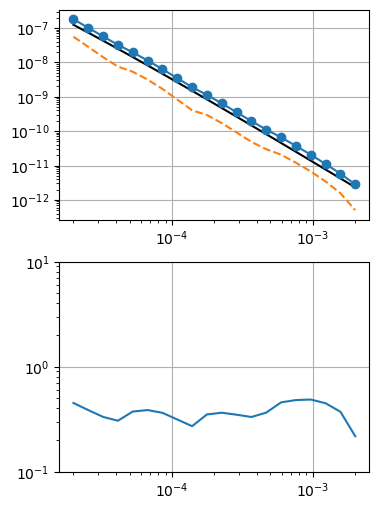

In [295]:
fig, ax = plt.subplots(2, 1, figsize=(4, 6)) 
ax[0].loglog(rx_times, -dpred1d, color="k")
ax[0].loglog(rx_times, -dpred_halfspace, "C0-o")

ax[0].loglog(rx_times, np.abs(dpred_halfspace-dpred1d), "C1--")

ax[1].loglog(rx_times, np.abs(dpred_halfspace-dpred1d)/np.abs(dpred1d))
ax[1].set_ylim(1e-1, 10)

for a in ax.flatten():
    a.grid()

In [268]:
target_z_center

-70

In [269]:
target_thickness

60

In [270]:
sim1d_target = get_sim1d(
    thicknesses=[
        -target_z_center-target_thickness/2,
        target_thickness
    ],
    rx_loc = np.atleast_2d(rx_locs[rx_ind, :])
)

In [271]:
dpred1d_target = sim1d_target.dpred(np.log(np.r_[sigma_back, sigma_target, sigma_back]))

In [272]:
%%time
key="target_0"
dpred_target = sim.dpred(log_conductivity_models_2d[key])

CPU times: user 2min 55s, sys: 12.9 s, total: 3min 7s
Wall time: 9.27 s


In [273]:
dpred1d_target

array([-2.23726181e-07, -1.72069884e-07, -1.31237637e-07, -9.92567914e-08,
       -7.46419083e-08, -5.59820880e-08, -4.18163788e-08, -3.08576057e-08,
       -2.22347685e-08, -1.54843290e-08, -1.03552502e-08, -6.63079238e-09,
       -4.06213393e-09, -2.38176916e-09, -1.33831146e-09, -7.22153672e-10,
       -3.75275137e-10, -1.88474746e-10, -9.18650863e-11, -4.36565097e-11])

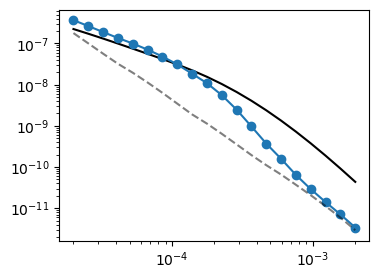

In [274]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3)) 
ax.loglog(rx_times, -dpred1d_target, color="k")
ax.loglog(rx_times, -dpred_target, "C0-o")
ax.loglog(rx_times, -dpred_halfspace, "--k", alpha=0.5)

# run all simulations

In [275]:
data_directory = "./synthetic-data-2d-20m"

In [276]:
mesh.save(f"{data_directory}/mesh.json")

'/home/lheagy/git/simpeg-research/2025-heagy-etal-tle/notebooks/synthetic-data-2d-20m/mesh.json'

In [277]:
with open(f"{data_directory}/true_models3d.pkl", "wb") as f:
    pickle.dump(models, f)

In [278]:
with open(f"{data_directory}/log_conductivity_models_2d.pkl", "wb") as f:
    pickle.dump(log_conductivity_models_2d, f)

In [279]:
np.save(f"{data_directory}/rx_times.npy", rx_times)
np.save(f"{data_directory}/rx_locs.npy", rx_locs)

In [280]:
dpred_dict = {}

In [281]:
def run_simulation(key):
    print(f"Starting {key}")
    t = time.time()
    model = log_conductivity_models_2d[key]
    sim = get_sim(mesh.copy(), mesh_2d.copy())
    dpred = sim.dpred(model)
    np.save(f"{data_directory}/dpred_{key}.npy", dpred)
    elapsed = time.time() - t
    print(f".... done. Elapsed time = {elapsed:1.2e}s \n")
    return key, dpred

In [282]:
for key in model_keys:
    if key not in dpred_dict.keys(): 
        key, dpred = run_simulation(key)
        dpred_dict[key] = dpred

Starting background
.... done. Elapsed time = 6.54e+01s 

Starting target_0
.... done. Elapsed time = 6.38e+01s 

Starting target_15
.... done. Elapsed time = 6.84e+01s 

Starting target_30
.... done. Elapsed time = 6.80e+01s 

Starting target_45
.... done. Elapsed time = 6.41e+01s 



In [283]:
# # dpred_dict = {}

# with ThreadPoolExecutor() as executor:
#     futures = [executor.submit(run_simulation, key) for key in model_keys if key not in dpred_dict.keys()]
#     for future in as_completed(futures):
#         key, dpred = future.result()
#         dpred_dict[key] = dpred

In [286]:
for k in models.keys(): 
    if k not in dpred_dict.keys(): 
        dpred_dict[k] = np.load(f"{data_directory}/dpred_{k}.npy")

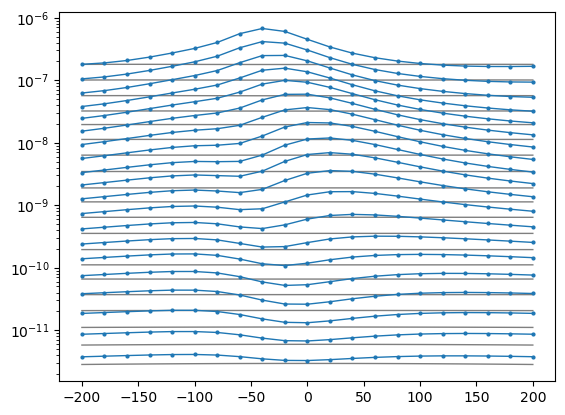

In [287]:
fig, ax = plt.subplots(1, 1) 

key = "target_45" 

ax.semilogy(
    rx_x, -dpred_dict["background"].reshape(len(rx_x), len(rx_times)), color="k", lw=1, alpha=0.5
);
ax.semilogy(
    rx_x, -dpred_dict[key].reshape(len(rx_x), len(rx_times)), "C0-o", lw=1, ms=2
);
